In [1]:
from Favorfit_remove_bg import inference as remove_bg
from Favorfit_image_to_text import clip_image_to_text

rmbg_model = remove_bg.call_model("/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/remove_bg/remove_bg.pth", device="cuda")
clip_model = clip_image_to_text.load_interrogator("/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/image_to_text/clip", device="cuda")

/home/mlfavorfit/anaconda3/envs/diffusion_rnd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mlfavorfit/anaconda3/envs/diffusion_rnd/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [2]:
import random
from PIL import Image
from PIL.ImageOps import expand

from diffusers.utils import make_image_grid
from utils import *

import torch
from diffusers import KandinskyV22PriorPipeline
# from diffusers.pipelines.kandinsky2_2.pipline_kandinsky2_2_controlnet_split import KandinskyV22ControlnetPipeline
from diffusers.pipelines.kandinsky2_2.pipline_kandinsky2_2_controlnet_text import KandinskyV22ControlnetPipeline

from diffusers.models.controlnet_kandinsky import ControlNetModel as ControlNetModelKandinsky


In [3]:
pr_path = "/home/mlfavorfit/Downloads/sample/composition/5_pr.jpg"
tp_path = "/home/mlfavorfit/Downloads/sample/composition/5_tp.jpg"

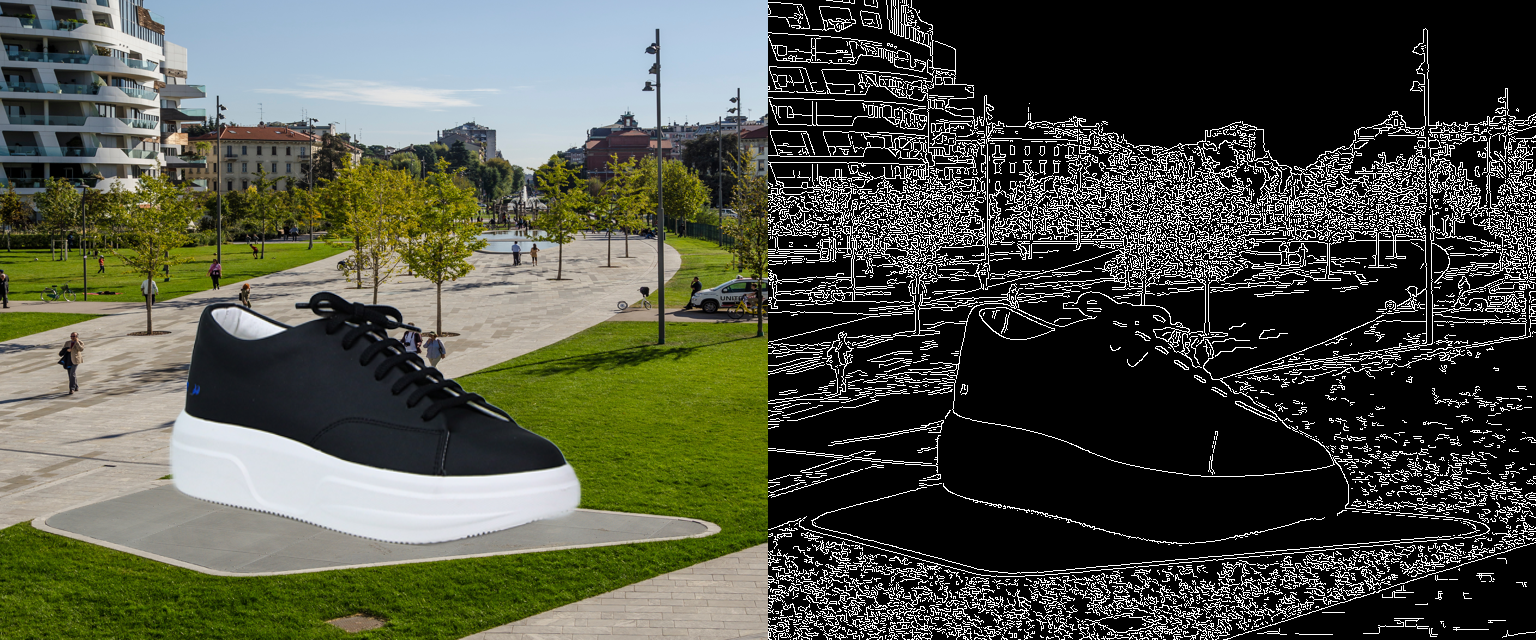

In [4]:
init_image = resize_store_ratio(Image.open(pr_path))
mask = remove_bg.inference(init_image, rmbg_model).convert("L")

def transform_image_and_mask(border, scale_x, scale_y):
    global init_image, mask
    
    ori_width, ori_height = init_image.size

    # 확대
    new_width = int(init_image.width * scale_x)
    new_height = int(init_image.height * scale_y)
    init_image = init_image.resize((new_width, new_height))
    mask = mask.resize((new_width, new_height))
    
    var_width = (new_width - ori_width)/2
    var_height = (new_height - ori_height)/2

    # 이미지 잘라내기
    init_image = init_image.crop((var_width, var_height, new_width-var_width, new_height-var_height))
    mask = mask.crop((var_width, var_height, new_width-var_width, new_height-var_height))

    init_image = expand(init_image, border=border)
    mask = expand(mask, border=border)
    
    init_image = init_image.resize((round(cur/64) * 64 for cur in init_image.size))
    mask = mask.resize((round(cur/64) * 64 for cur in mask.size))
    

transform_image_and_mask(border=(0,100,0,0), scale_x=1.2, scale_y=1.2)

tp = center_crop_and_resize(Image.open(tp_path), target_size=init_image.size)

init_image = composing_image(tp, init_image, mask.convert("RGB"))
canny_image = make_canny_condition(init_image)
width, height = init_image.size
make_image_grid([init_image, canny_image], rows=1, cols=2)

In [5]:
decoder_model_path = "/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/diffusion/Kandinsky/kandinsky-decoder"
prior_model_path = "/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/diffusion/Kandinsky/kandinsky-prior"

controlnet_kandinsky = ControlNetModelKandinsky.from_pretrained(
    decoder_model_path, subfolder="controlnet/tile_from_sd15", torch_dtype=torch.float16
).eval()

prior_pipeline = KandinskyV22PriorPipeline.from_pretrained(
    prior_model_path,
    use_safetensors=True,
    torch_dtype=torch.float16,
)

pipeline = KandinskyV22ControlnetPipeline.from_pretrained(
    decoder_model_path,
    controlnet=controlnet_kandinsky,
    torch_dtype=torch.float16,
)

The config attributes {'center_input_sample': False} were passed to ControlNetModel, but are not expected and will be ignored. Please verify your config.json configuration file.
Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00,  7.64it/s]


In [6]:
important_keywords = ", natural materials :: high detail, behance. polished, trending on textures. com, clean 3 d render, raytraced 3d set design, raytracing shadows, image on the store website"
caption = clip_image_to_text.inference(init_image, clip_model, mode="fast")
caption

'the grass is green, inflatable future shoes, sneaker design, floating over a city sidewalk, stepping on the city, 3 d ue 5, stylish shoe design, platform game, ue5 render, futuristic balenciaga sneakers, 3 d product render, concept image, palace floating in heaven, product render, 3d matte render, hyper real render, smooth 3d cg render'

In [7]:
prompt = f"{caption}"
negative_prompt = "low quality, worst quality, wrinkled, deformed, distorted, jpeg artifacts, nsfw, paintings, sketches, text, watermark, username, spikey"

seed = random.randint(0,10000)

In [8]:
prior_pipeline = prior_pipeline.to("cuda")
pipeline = pipeline.to("cuda")

generator = torch.Generator(device="cuda").manual_seed(seed)

with torch.autocast("cuda", torch.float16):
    prior_output = prior_pipeline(
        prompt=prompt, 
        negative_prompt=negative_prompt, 
        generator=generator,
    )

    generated_image = pipeline(
        prompt=prompt,
        negative_prompt=negative_prompt,
        image=init_image,
        control_image=canny_image,
        **prior_output,
        height=height,
        width=width,
        num_inference_steps=20,
        strength=0.2,
        guidance_scale=2.0,
        controlnet_scale=1.0,
        generator=generator,
    ).images[0]

 25%|██▌       | 1/4 [00:00<00:00,  4.57it/s]

16 16
torch.Size([2, 320, 80, 96])
torch.Size([2, 384, 80, 96])
torch.Size([2, 320, 80, 96])
torch.Size([2, 384, 80, 96])
torch.Size([2, 320, 80, 96])
torch.Size([2, 384, 80, 96])
torch.Size([2, 320, 80, 96])
torch.Size([2, 384, 80, 96])
torch.Size([2, 320, 40, 48])
torch.Size([2, 384, 40, 48])
torch.Size([2, 640, 40, 48])
torch.Size([2, 768, 40, 48])
torch.Size([2, 640, 40, 48])
torch.Size([2, 768, 40, 48])
torch.Size([2, 640, 40, 48])
torch.Size([2, 768, 40, 48])
torch.Size([2, 640, 20, 24])
torch.Size([2, 768, 20, 24])
torch.Size([2, 1280, 20, 24])
torch.Size([2, 1152, 20, 24])
torch.Size([2, 1280, 20, 24])
torch.Size([2, 1152, 20, 24])
torch.Size([2, 1280, 20, 24])
torch.Size([2, 1152, 20, 24])
torch.Size([2, 1280, 10, 12])
torch.Size([2, 1152, 10, 12])
torch.Size([2, 1280, 10, 12])
torch.Size([2, 1536, 10, 12])
torch.Size([2, 1280, 10, 12])
torch.Size([2, 1536, 10, 12])
torch.Size([2, 1280, 10, 12])
torch.Size([2, 1536, 10, 12])
2 torch.Size([2, 384, 80, 96])
2 torch.Size([2, 384,

 75%|███████▌  | 3/4 [00:00<00:00,  5.31it/s]

16 16
torch.Size([2, 320, 80, 96])
torch.Size([2, 384, 80, 96])
torch.Size([2, 320, 80, 96])
torch.Size([2, 384, 80, 96])
torch.Size([2, 320, 80, 96])
torch.Size([2, 384, 80, 96])
torch.Size([2, 320, 80, 96])
torch.Size([2, 384, 80, 96])
torch.Size([2, 320, 40, 48])
torch.Size([2, 384, 40, 48])
torch.Size([2, 640, 40, 48])
torch.Size([2, 768, 40, 48])
torch.Size([2, 640, 40, 48])
torch.Size([2, 768, 40, 48])
torch.Size([2, 640, 40, 48])
torch.Size([2, 768, 40, 48])
torch.Size([2, 640, 20, 24])
torch.Size([2, 768, 20, 24])
torch.Size([2, 1280, 20, 24])
torch.Size([2, 1152, 20, 24])
torch.Size([2, 1280, 20, 24])
torch.Size([2, 1152, 20, 24])
torch.Size([2, 1280, 20, 24])
torch.Size([2, 1152, 20, 24])
torch.Size([2, 1280, 10, 12])
torch.Size([2, 1152, 10, 12])
torch.Size([2, 1280, 10, 12])
torch.Size([2, 1536, 10, 12])
torch.Size([2, 1280, 10, 12])
torch.Size([2, 1536, 10, 12])
torch.Size([2, 1280, 10, 12])
torch.Size([2, 1536, 10, 12])
2 torch.Size([2, 384, 80, 96])
2 torch.Size([2, 384,

100%|██████████| 4/4 [00:00<00:00,  5.28it/s]


2 torch.Size([2, 384, 80, 96])
2 torch.Size([2, 384, 80, 96])
2 torch.Size([2, 384, 80, 96])
2 torch.Size([2, 384, 80, 96])
2 torch.Size([2, 384, 40, 48])
2 torch.Size([2, 768, 40, 48])
2 torch.Size([2, 768, 40, 48])
2 torch.Size([2, 768, 40, 48])
2 torch.Size([2, 768, 20, 24])
2 torch.Size([2, 1152, 20, 24])
2 torch.Size([2, 1152, 20, 24])
2 torch.Size([2, 1152, 20, 24])
2 torch.Size([2, 1152, 10, 12])
2 torch.Size([2, 1536, 10, 12])
2 torch.Size([2, 1536, 10, 12])
2 torch.Size([2, 1536, 10, 12])


/home/mlfavorfit/lib/favorfit/kjg/diffusers_research/diffusers_research/diffusers/utils/pil_utils.py:43: RuntimeWarning: invalid value encountered in cast
  images = (images * 255).round().astype("uint8")


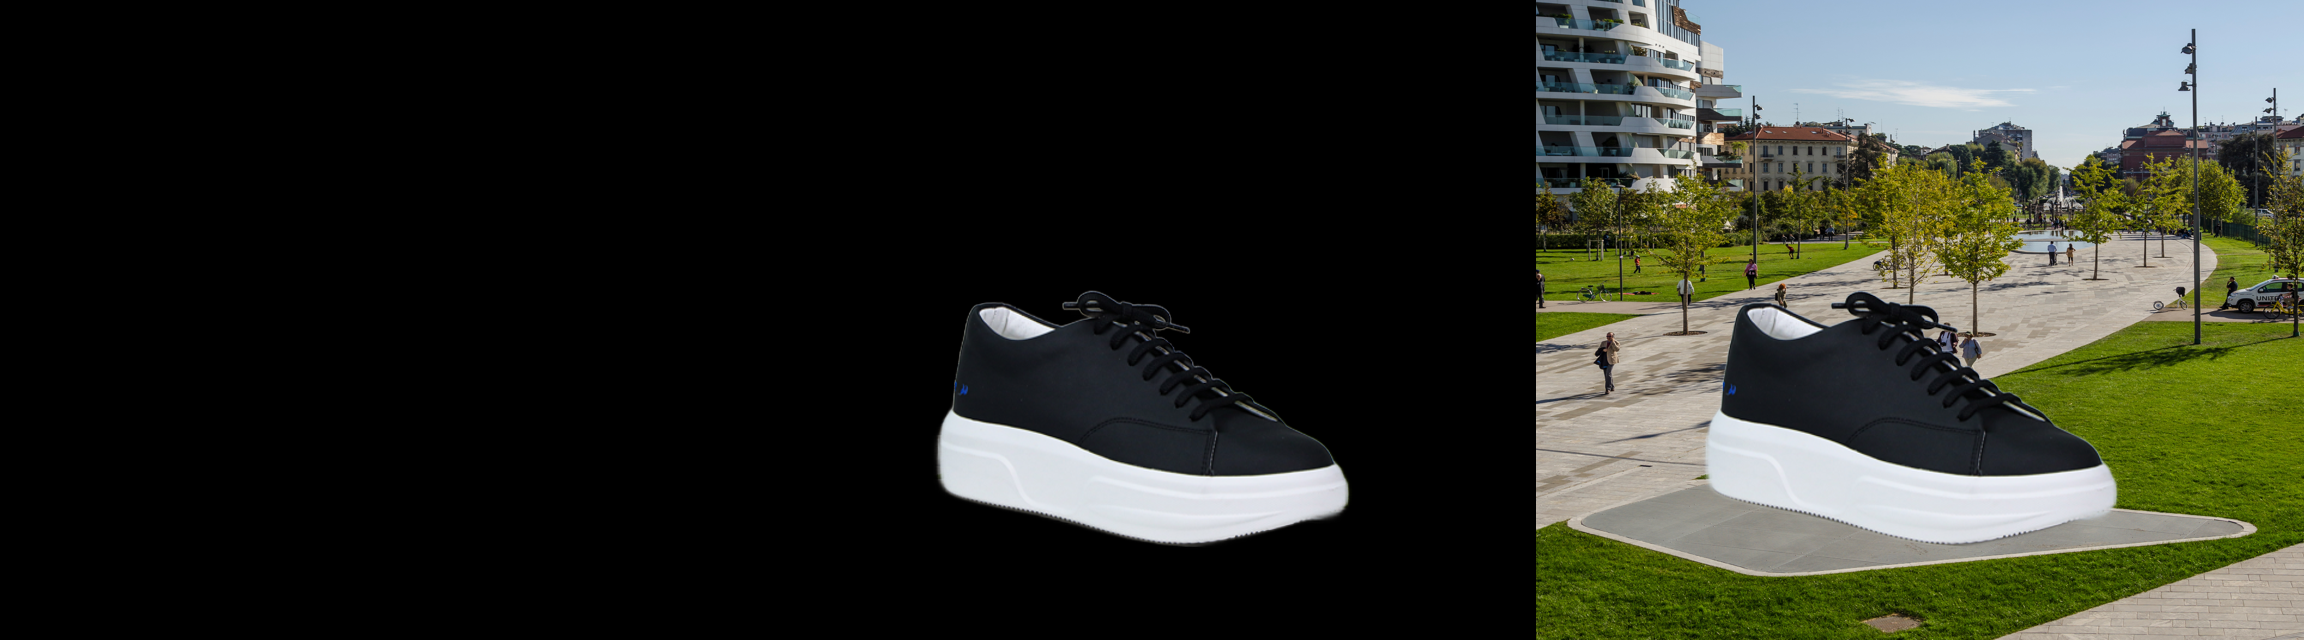

In [9]:
composed_image = composing_image(generated_image, init_image, mask.convert("RGB"))
make_image_grid([generated_image, composed_image, init_image], rows=1, cols=3)

In [10]:
import numpy as np
from PIL.ImageOps import invert

expand_mask = cv2.dilate(np.array(mask.convert("L")), (3,3), iterations=50)
expand_mask

mask_np = np.array(invert(mask.convert("L")))
exp_mask_np = np.array(expand_mask)

combine_mask = mask_np * (exp_mask_np/255) + exp_mask_np * (1-exp_mask_np/255)
combine_mask = Image.fromarray(combine_mask).convert("RGB")

In [11]:
from diffusers.pipelines.kandinsky2_2.pipeline_kandinsky2_2_inpainting import KandinskyV22InpaintPipeline

prior_pipeline = KandinskyV22PriorPipeline.from_pretrained("kandinsky-community/kandinsky-2-2-prior", torch_dtype=torch.float16, use_safetensors=True).to("cuda")
pipeline = KandinskyV22InpaintPipeline.from_pretrained("kandinsky-community/kandinsky-2-2-decoder-inpaint", torch_dtype=torch.float16, use_safetensors=True).to("cuda")


prior_output = prior_pipeline(
    prompt=prompt,
    negative_prompt=negative_prompt,
    generator=generator
    )
output_image = pipeline(image=init_image, 
                        mask_image=combine_mask, 
                        **prior_output, 
                        height=height, 
                        width=width, 
                        num_inference_steps=50,
                        strength=0.3,
                        guidance_scale=2.0,
                        generator=generator).images[0]

100%|██████████| 15/15 [00:01<00:00, 10.35it/s]


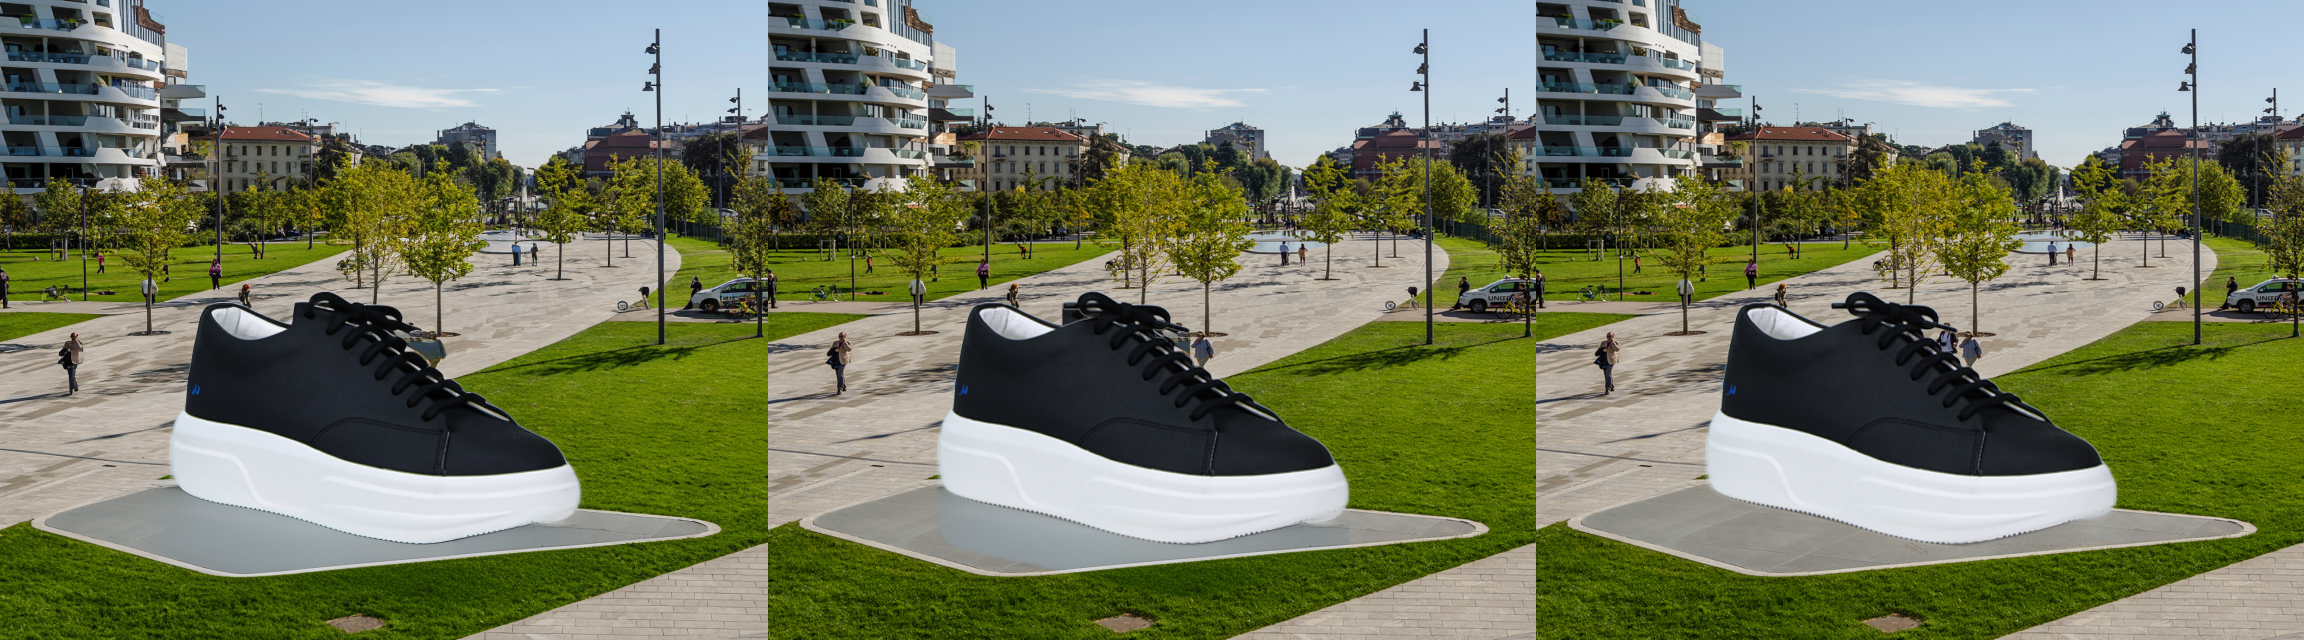

In [12]:
composed_image = composing_image(init_image, output_image, combine_mask.convert("RGB"))
make_image_grid([output_image, composed_image, init_image], rows=1, cols=3)